In [433]:
import math
import mmgdynamics as mmg
import mmgdynamics.calibrated_vessels as cvs
import matplotlib.pyplot as plt # Just for demostration

from collections import namedtuple
import numpy as np
import scipy

In [434]:
def state2comp(s: np.ndarray):
    pos = s[:2]
    psi = s[2]
    uvr = s[3:]
    return pos, psi, uvr

def input2comp(u: np.ndarray):
    nps = u[0]
    delta = u[1]
    return nps, delta

def create_idx(nx, nu, N):
    idx = namedtuple("idx", ['nx', 'nu', 'N', 'nz', 'nc', 's', 'u', 'c'])

    nz = (N-1) * nu + N * nx

    s = [i * (nx + nu) for i in range(N)]
    u = [i * (nx + nu) + nx for i in range(N-1)]

    nc = (N-1) * nx
    c = [i * nx for i in range(N-1)]

    return idx(nx=nx, nu=nu, N=N, nz=nz, nc=nc, s=s, u=u, c=c)

def Z2comp(Z: np.ndarray, idx):
    S = []
    for i in range(idx.N):
        start = idx.s[i]
        end = start + idx.nx
        S.append(Z[start:end])

    U = []
    for i in range(idx.N-1):
        start = idx.u[i]
        end = start + idx.nu
        U.append(Z[start:end])

    return np.array(S), np.array(U)

In [ ]:
def dynamics(vessel, s, u, dt):
    pos, psi, uvr = state2comp(s=s)
    nps, delta = input2comp(u=u)

    uvr, eta = mmg.pstep(
        X           = uvr,
        pos         = pos,
        vessel      = vessel,
        dT          = dt,       # in seconds
        nps         = nps,      # propeller (nps) revs per second
        delta       = delta,    # rudder (delta) angle in radians
        psi         = psi,      # vessel (psi) heading in radians
        water_depth = None,     # No water depth
        fl_psi      = None,     # No current angle
        fl_vel      = None,     # No current velocity
        w_vel       = None,     # No wind velocity
        beta_w      = None      # No wind angle
    )

    duvr = mmg.step(
        X           = uvr,
        vessel      = vessel,
        dT          = dt,       # in seconds
        nps         = nps,      # propeller (nps) revs per second
        delta       = delta,    # rudder (delta) angle in radians
        psi         = psi,      # vessel (psi) heading in radians
        water_depth = None,     # No water depth
        fl_psi      = None,     # No current angle
        fl_vel      = None,     # No current velocity
        w_vel       = None,     # No wind velocity
        beta_w      = None      # No wind angle
    )

    sp1 = np.concatenate((eta, uvr))
    Δs = np.concatenate((eta, duvr))
    return sp1, Δs

In [436]:
def hermite_simpson(Z, vessel, dt, idx, state_num):
    S, U = Z2comp(Z, idx)
    s1 = S[state_num]
    s2 = S[state_num+1]
    u = U[state_num]

    _, Δs1 = dynamics(vessel, s1, u, dt)
    _, Δs2 = dynamics(vessel, s2, u, dt)

    s_mid = 1/2 * (s1 + s2) + dt/8 * (Δs1 - Δs2)
    _, Δs_mid = dynamics(vessel, s_mid, u, dt)

    f = s1 + dt/6 * (Δs1 + 4 * Δs_mid + Δs2) - s2
    return np.linalg.norm(f)

def forward_euler(Z, vessel, dt, idx, state_num):
    S, U = Z2comp(Z, idx)
    s1 = S[state_num]
    s2 = S[state_num+1]
    u = U[state_num]

    sp1, Δs1 = dynamics(vessel, s1, u, dt)

    f = sp1 - s2
    return np.linalg.norm(f)

def init_constraint(Z, idx, si):
    S, U = Z2comp(Z, idx)
    f = S[0] - si
    return f

def term_constraint(Z, idx, sg):
    S, U = Z2comp(Z, idx)
    f = S[-1] - sg
    return f

def obstacle(Z, idx, state_num):
    S, U = Z2comp(Z, idx)
    state = S[state_num]
    f = (state[0] - 25)**2 + (state[1] - 25)**2 - 20**2
    return f


In [437]:
def LQR_cost(Z, Q, R, Qf, sg, idx):
    S, U = Z2comp(Z, idx)

    J = 0
    for i in range(idx.N-1):
        J += 0.5 * (S[i] - sg)@Q@(S[i] - sg) + 0.5 * U[i]@R@U[i]

    J += 0.5 * (S[-1] - sg)@Qf@(S[-1] - sg)

    return J

In [438]:
def create_constraints(vessel, idx, dt, si, sg):
    constraints = []

    # dynamics constraints
    for i in range(idx.N-1):
        #c = {'type': 'eq', 'fun': hermite_simpson, 'args': (vessel, dt, idx, i)}
        c = {'type': 'eq', 'fun': forward_euler, 'args': (vessel, dt, idx, i)}
        #constraints.append(c)

    # equality constraints
    constraints.append({'type': 'eq', 'fun': init_constraint, 'args': (idx, si)})
    constraints.append({'type': 'eq', 'fun': term_constraint, 'args': (idx, sg)})

    # inequality constraints
    #for i in range(idx.N-1):
        #constraints.append({'type': 'ineq', 'fun': obstacle, 'args': (idx, i)})

    return constraints

def create_bounds(idx):
    bounds = [(-np.inf, np.inf) for i in range(idx.nz)]
    
    for index in idx.u:
        bounds[index] = (-5, 5)
        bounds[index+1] = (-np.pi, np.pi)

    return bounds


In [439]:
# Load a pre-calibrated vessel
import scipy.optimize

vessel = mmg.Vessel(**cvs.kvlcc2_l64)

# Inital state
si = np.array([0., 0., 0., 0., 0., 0.])
ui = np.array([0., 0.])

# Target state
sg = np.array([500.0, 500.0, 0., 0., 0., 0.])
ug = np.array([0., 0.])

# Indexing variables
N = 50 # number of timesteps
nx = 6 # size of the state
nu = 2 # size of the input
idx = create_idx(nx, nu, N)

# Random generator
seed = 23485293424983893517625869594581
rng = np.random.default_rng(seed=seed)

# Collocation Variables
dt = 1
Z = np.zeros(N*nx + (N-1)*nu)
Sinit = np.linspace(si, sg, N)# initial guess
for i in range(N):
    Z[idx.s[i]:idx.s[i]+nx] = Sinit[i]
print(Z)
Z = Z.flatten()

# Error checking
print(N*nx + (N-1)*nu)
assert len(Z) == N*nx + (N-1)*nu

S, U = Z2comp(Z, idx)
assert np.shape(S) == (N, nx)
assert np.shape(U) == (N-1, nu)

#print(Z)
#print(S)
#print(U)

# optimize
Q = np.eye(nx)
R = np.eye(nu)
Qf = 2*np.eye(nx)
constraints = create_constraints(vessel, idx, dt, si, sg)
bounds = create_bounds(idx)

#print(constraints)

result = scipy.optimize.minimize(fun=LQR_cost, x0=Z, args=(Q, R, Qf, sg, idx), method="SLSQP", bounds=bounds, constraints=constraints)
#result = scipy.optimize.minimize(fun=LQR_cost, x0=Z, args=(Q, R, Qf, sg, idx), method="SLSQP", constraints=constraints)
#result = scipy.optimize.minimize(fun=LQR_cost, x0=Z, args=(Q, R, Qf, sg, idx), method="SLSQP")
states, U = Z2comp(result.x, idx)

[  0.           0.           0.           0.           0.
   0.           0.           0.          10.20408163  10.20408163
   0.           0.           0.           0.           0.
   0.          20.40816327  20.40816327   0.           0.
   0.           0.           0.           0.          30.6122449
  30.6122449    0.           0.           0.           0.
   0.           0.          40.81632653  40.81632653   0.
   0.           0.           0.           0.           0.
  51.02040816  51.02040816   0.           0.           0.
   0.           0.           0.          61.2244898   61.2244898
   0.           0.           0.           0.           0.
   0.          71.42857143  71.42857143   0.           0.
   0.           0.           0.           0.          81.63265306
  81.63265306   0.           0.           0.           0.
   0.           0.          91.83673469  91.83673469   0.
   0.           0.           0.           0.           0.
 102.04081633 102.04081633   0.           

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.99999883e+02 4.99999883e+02 2.66057721e-14 1.67398368e-15
  0.00000000e+00 0.00000000e+00]
 [5.00000010e+02 5.00000010e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.99999453e+02 4.99999453e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.99999917e+02 4.99999917e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.00000848e+02 5.00000848e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.00000537e+02 5.00000537e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.99999950e+02 4.99999950e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.99999830e+02 4.99999830e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.99999710e+02 4.99999710e+02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.99999838e+02 4.99999838e+02 0.00000000e+00 0.0

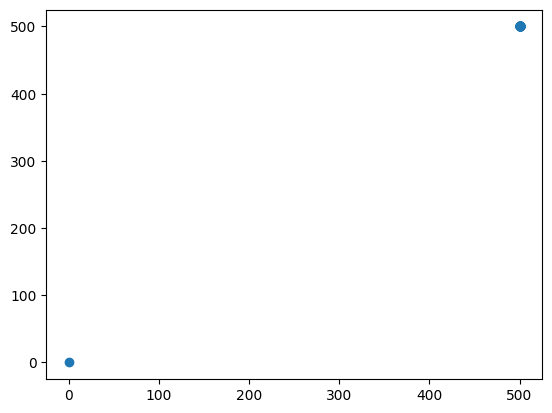

In [440]:
print(states)
#print(U)
ps = list(zip(*states))
plt.scatter(ps[0], ps[1])
plt.show()